In [1]:
%%capture
%cd ..

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML
from pathlib import Path
save_file = Path('data')/'Nth_Taylor.csv'

# High-order Taylor methods

$$
y_{i+1} = y_i + hT^{(N)}_i,\quad T^{(N)}_i = \sum_{n=0}^N \frac{h^n}{(n+1)!} f^{(n)}(t_i, y_i)
$$

In [4]:
from dataclasses import dataclass
from typing import Callable
from math import factorial
import sympy as sp

def get_fs(f, m: int):
    t = sp.symbols('t')
    y = sp.Function('y')(t)
    dy = y.diff(t)
    f_sym = [f(t, y)]
    for _ in range(m):
        f_sym.append(f_sym[-1].diff(t).subs(dy, f_sym[0]))
    return [sp.lambdify((t, y), fs, 'numpy') for fs in f_sym]

@dataclass
class IVP:
    f:  Callable
    t0: float
    y0: float
    h:  float
    tf: float=np.inf

    @property
    def N(self) -> int: 
        return int(abs(self.tf - self.t0)/self.h)
    
    def __str__(self):
        t, y = sp.symbols('t, y')
        return r'$f(t, y) = {}$'.format(sp.latex(self.f(t, y)))

class Nth_Taylor:
    def __init__(self, ivp: IVP, m: int=1):
        self.h = ivp.h
        self._y = [ivp.y0]
        self._t = [ivp.t0]

        self.m = m
        self.fs = get_fs(ivp.f, m)

    def _T(self, n: int):
        return self.fs[n](self._t[-1], self._y[-1]) * self.h**n/factorial(n+1)
    
    @property
    def y(self):
        return np.stack(self._y)

    @property
    def t(self):
        return np.stack(self._t)
    
    def to_dataframe(self):
        return pd.DataFrame({
            't': self.t,
            'y':self.y
        })

    def reset(self):
        self._y = [self._y[0]]
        self._t = [self._t[0]]
    
    def step(self):
        self._y.append(self._y[-1] + self.h*sum(map(self._T, range(self.m))))
        self._t.append(self._t[-1] + self.h)
    
    def forward(self, steps: int=1):
        for _ in range(steps): self.step()

In [5]:
from threading import Thread, Condition
from queue import Queue

class Threaded_Nth_Taylor(Nth_Taylor):
    def __enter__(self):
        self.queue = Queue()
        self.condition = Condition()
        self.running = True
        for n in range(self.m):
            Thread(target=self._task, args=(n, )).start()
        return self

    def __exit__(self, *args):
        self.running = False
        with self.condition: self.condition.notify_all()

    def _task(self, n: int):
        while self.running:
            with self.condition: self.condition.wait()
            self.queue.put(self._T(n))

    def step(self):
        with self.condition: self.condition.notify_all()
        T = 0
        for _ in range(self.m):
            T += self.queue.get()
        self._y.append(self._y[-1] + self.h*T)
        self._t.append(self._t[-1] + self.h)

In [40]:
import multiprocessing as mp
from ctypes import c_float, c_int, c_bool

class Multi_Nth_Taylor:
    def __init__(self, ivp: IVP, m: int=1):
        self._h = mp.Value(c_float, ivp.h)
        self._N = ivp.N
        self._y = mp.Array(c_float, [ivp.y0, *[0]*self._N])
        self._t = mp.Array(c_float, ivp.t0 + ivp.h*np.arange(ivp.N + 1))
        self._step = mp.Value(c_int, 0)

        self.m = m
        self.fs = get_fs(ivp.f, m)

    def _T(self, n, f):
        return f(self._t[self._step.value], self._y[self._step.value]) * self._h.value**n/factorial(n+1)
    
    @property
    def y(self):
        return np.stack(self._y.get_obj())

    @property
    def t(self):
        return np.stack(self._t.get_obj())
    
    def to_dataframe(self):
        return pd.DataFrame({
            't': self.t,
            'y':self.y
        })

    def reset(self):
        with self.locker:
            self._step.value = 0
    
    def __enter__(self):
        self.queue = mp.Queue()
        self.condition = mp.Condition()
        self.running = mp.Value(c_bool, True)
        self.locker = mp.Lock()

        self.processes = []
        for n in range(self.m):
            self.processes.append(mp.Process(target=self._task, args=(n, self.fs[n])))
            self.processes[-1].start()
            
        return self

    def __exit__(self, *args):
        with self.locker:
            self.running.value = False
        with self.condition: self.condition.notify(self.m)
        # for process in self.processes: 
        #     process.kill()

    def _task(self, n: int, f):
        with self.condition:
            while self.running.value:
                self.queue.put(self._T(n, f))
                self.condition.wait()

    def step(self):
        T = 0
        for _ in range(self.m):
            T += self.queue.get()
        with self.locker:
            self._y[self._step.value + 1] = self._y[self._step.value] + self._h.value*T
            self._t[self._step.value + 1] = self._t[self._step.value] + self._h.value
            self._step.value += 1
        with self.condition:
            self.condition.notify(self.m)
    
    def forward(self):
        for _ in range(self._N):             
            self.step()

## Testing

$$
f(t, y) = y - t^2 + 1, \quad y(0) = 0.5, \quad h=0.2
$$

In [7]:
problem = IVP(lambda t, y: y - t**2 + 1, t0=0, y0=0.5, h=0.2, tf=2)
solution = lambda t: -np.exp(t)/2 + t**2 + 2*t + 1

In [8]:
solver = Nth_Taylor(problem, m=5)
%time solver.forward(10)
result = solver.to_dataframe()
result['|y(ti) - yi|'] = abs(solution(result.t) - result.y)
display(HTML(result.to_html()))

CPU times: user 57 µs, sys: 41 µs, total: 98 µs
Wall time: 103 µs


,t,y,|y(ti) - yi|
0,0.0,0.500000,0.000000e+00
1,0.2,0.829299,4.574675e-08
2,0.4,1.214088,1.117504e-07
3,0.6,1.648941,2.047384e-07
4,0.8,2.127230,3.334240e-07
5,1.0,2.640860,5.090563e-07
6,1.2,3.179942,7.461152e-07
7,1.4,3.732401,1.063192e-06
8,1.6,4.283485,1.484097e-06
9,1.8,4.815178,2.039266e-06


In [9]:
with Threaded_Nth_Taylor(problem, m=5) as solver:
    %time solver.forward(10)
    display(HTML(solver.to_dataframe().to_html()))

CPU times: user 3.54 ms, sys: 0 ns, total: 3.54 ms
Wall time: 2.87 ms


,t,y
0,0.0,0.500000
1,0.2,0.829299
2,0.4,1.214088
3,0.6,1.648941
4,0.8,2.127230
5,1.0,2.640860
6,1.2,3.179942
7,1.4,3.732401
8,1.6,4.283485
9,1.8,4.815178


In [62]:
with Multi_Nth_Taylor(problem, m=5) as solver:
    %time solver.forward()
    display(HTML(solver.to_dataframe().to_html()))

CPU times: user 866 µs, sys: 483 µs, total: 1.35 ms
Wall time: 7.9 ms


,t,y
0,0.0,0.500000
1,0.2,0.829299
2,0.4,1.214088
3,0.6,1.648941
4,0.8,2.127230
5,1.0,2.640860
6,1.2,3.179942
7,1.4,3.732401
8,1.6,4.283485
9,1.8,4.815178


## Comparison between sequential and threaded algorithm

In [ ]:
%%time

def timeit(function, *args, **kwargs):
    start = time.time()
    y = function(*args, **kwargs)
    stop = time.time()
    return stop-start, y

M = 10
problems = (
    IVP((lambda t, y: t*sp.exp(3*t) - 2*y), t0=0, y0=0, tf=10, h=0.1),
    IVP((lambda t, y: 1 + (t - y)**2), t0=2, y0=1, tf=10, h=0.1),
    IVP((lambda t, y: 1 + y/t), t0=1, y0=2, tf=10, h=0.1),
    IVP((lambda t, y: sp.cos(2*t) + sp.sin(3*t)), t0=0, y0=1, tf=10, h=0.1),
    IVP((lambda t, y: sp.exp(t - y)), t0=0, y0=1, tf=10, h=0.1),
    IVP((lambda t, y: (1 + t)/(1 + y)), t0=1, y0=1, tf=10, h=0.1),
    IVP((lambda t, y: -y + t*sp.sqrt(y)), t0=2, y0=1, tf=10, h=0.1),
    IVP((lambda t, y: t**(-2)*(sp.sin(2*t) - sp.sin(2*t*y))), t0=1, y0=1, tf=10, h=0.1)
)

columns = ('f', 't0', 'y0', 'tf', 'h', 'm', 'N', 'delay', 'solver')
df = []
for m in range(M):
    for ivp in problems:
        comum = (str(ivp), ivp.t0, ivp.y0, ivp.tf, ivp.h, m, ivp.N)

        solver = Nth_Taylor(ivp, m=m)
        delay, _ = timeit(solver.forward, ivp.N)
        df.append((*comum, delay, 'Nth_Taylor'))

        with Threaded_Nth_Taylor(ivp, m=m) as solver:
            delay, _ = timeit(solver.forward, ivp.N)
            df.append((*comum, delay, 'Threaded_Nth_Taylor'))    
        
        with Multi_Nth_Taylor(ivp, m=m) as solver:
            delay, _ = timeit(solver.forward)
            df.append((*comum, delay, 'Multi_Nth_Taylor'))    
        
        pd.DataFrame(df, columns=columns).to_csv(save_file, index=False)

df = pd.DataFrame(df, columns=columns)
df.to_csv(save_file)
df.head()

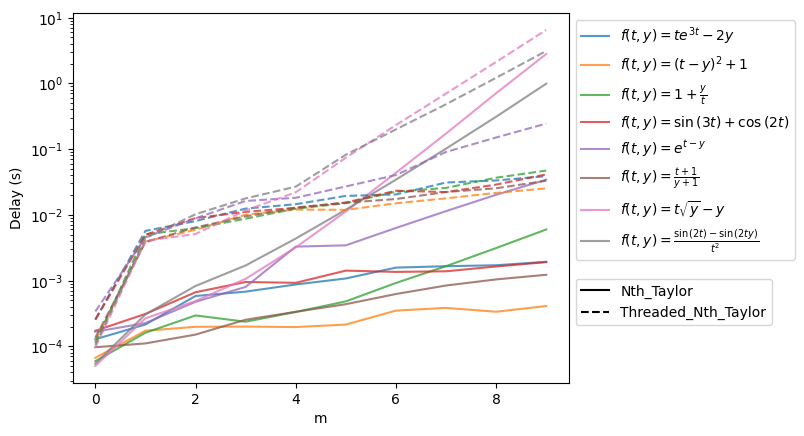

In [87]:
leg1 = []
leg2 = []
for solver_type, ls in zip(df.solver.unique()[:-1], ('-', '--', '-.')):
    line, = plt.plot([], [], f'k{ls}')
    leg1.append((line, solver_type))
    loc1 = df.solver == solver_type
    for i, f in enumerate(df.f.unique()):
        loc2 = df.f == f
        line, = plt.plot(df[loc1 & loc2].m, df[loc1 & loc2].delay, ls, c=f'C{i}', alpha=0.75)
        if ls == '-': leg2.append((line, f))
plt.semilogy()

plt.gca().add_artist(plt.legend(*np.stack(leg1).T, bbox_to_anchor=(1, 0.3)))
plt.legend(*np.stack(leg2).T, bbox_to_anchor=(1, 1))
plt.xlabel('m')
plt.ylabel('Delay (s)')
plt.show()
# plt.semilogx()

In [68]:
seq = df.solver == 'Nth_Taylor'
thr = df.solver == 'Threaded_Nth_Taylor'
mul = df.solver == 'Multi_Nth_Taylor'

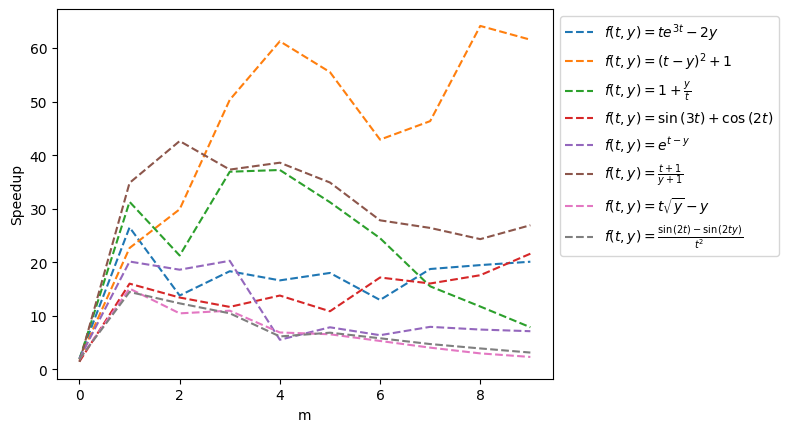

In [88]:
for f in df.f.unique():
    loc = df.f == f
    plt.plot(df.m.unique(), df[thr & loc].delay.values/df[seq & loc].delay.values, '--', label=f)
# plt.hlines(1, df.m.min(), df.m.max(), linestyles='-', color='gray', label='Speedup = 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('m')
plt.ylabel('Speedup')
plt.show()

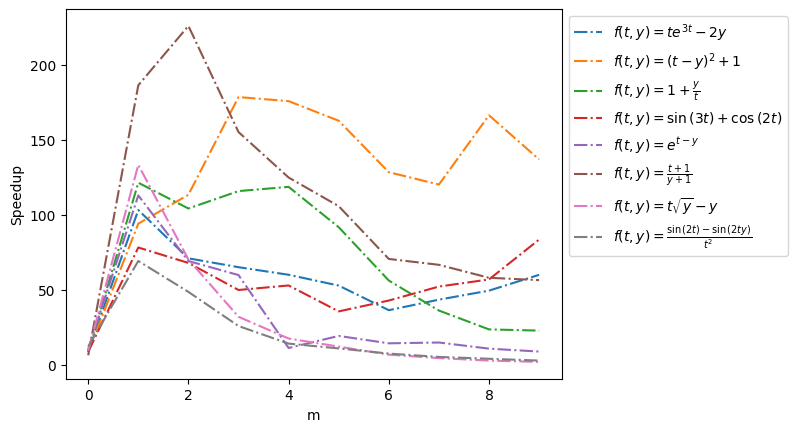

In [89]:
for f in df.f.unique():
    loc = df.f == f
    plt.plot(df.m.unique(), df[mul & loc].delay.values/df[seq & loc].delay.values, '-.', label=f)
# plt.hlines(1, df.m.min(), df.m.max(), linestyles='-', color='gray', label='Speedup = 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('m')
plt.ylabel('Speedup')
plt.show()

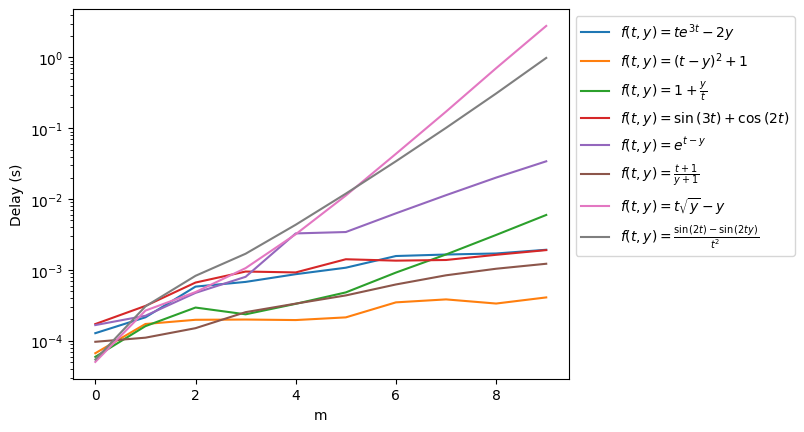

In [86]:
for f in df.f.unique():
    loc = df.f == f
    plt.plot(df.m.unique(), df[seq & loc].delay, '-', label=f)
# plt.hlines(1, df.m.min(), df.m.max(), linestyles='-', color='gray', label='Speedup = 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('m')
plt.ylabel('Delay (s)')
plt.semilogy()
plt.show()

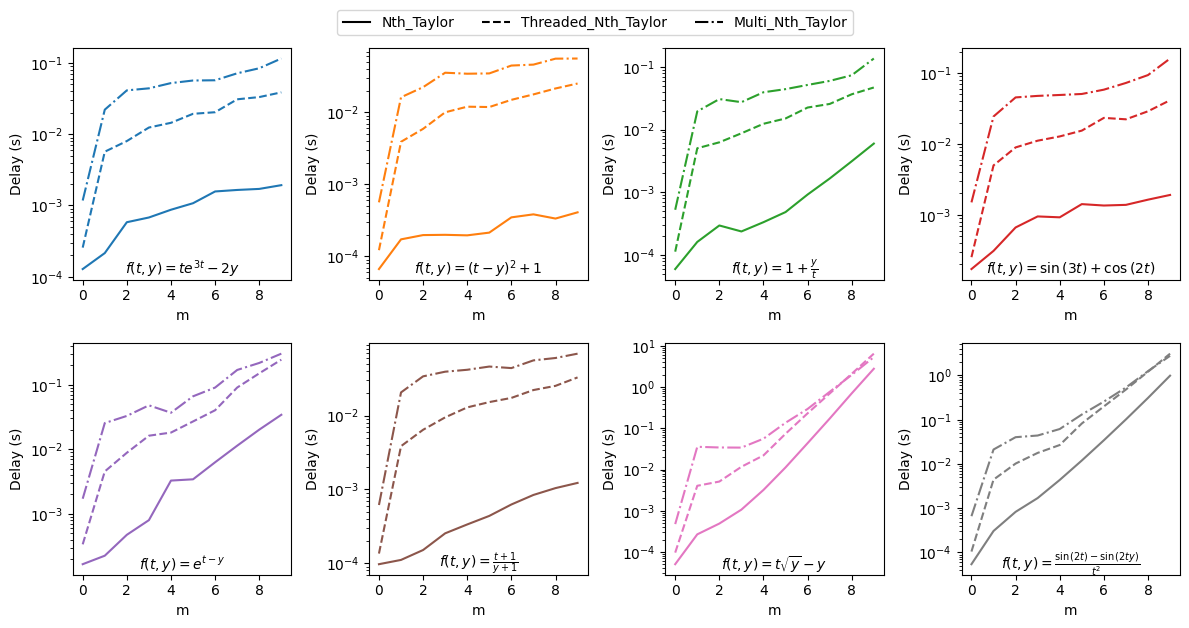

In [100]:
ax_width, ax_height = (3, 3)
cols = 4
rows = len(df.f.unique())//cols

fig, axs = plt.subplots(rows, cols, figsize=(ax_width*cols, ax_height*rows), )
axs = np.ravel(axs)

leg1 = []
leg2 = []
for solver_type, ls in zip(df.solver.unique(), ('-', '--', '-.')):
    line, = plt.plot([], [], f'k{ls}')
    leg1.append((line, solver_type))
    loc1 = df.solver == solver_type
    for i, f in enumerate(df.f.unique()):
        loc2 = df.f == f
        line, = axs[i].plot(df[loc1 & loc2].m, df[loc1 & loc2].delay, ls, c=f'C{i}')
        if ls == '-': 
            axs[i].text(df[loc1 & loc2].m.mean(), df[loc1 & loc2].delay.min(), f, ha='center', va='center')
            leg2.append((line, f))

for ax in axs: 
    ax.semilogy()
    ax.set_xlabel('m')
    ax.set_ylabel('Delay (s)')

fig.legend(*np.stack(leg1).T, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=3)
# axs[-1].legend(*np.stack(leg2).T, bbox_to_anchor=(1, 1))

fig.tight_layout()
plt.show()